

### **Imports**

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

### **Loading data**

In [78]:
df = pd.read_csv("failure_dataset.csv")
df

,operation_time,temperature,vibration,failures
0,1,68.727006,0.254003,2
1,2,97.535715,3.218411,2
2,3,86.599697,1.640344,2
3,4,79.932924,2.591996,3
4,5,57.800932,4.547076,2
...,...,...,...,...
95,96,74.689780,1.811127,1
96,97,76.136641,3.657183,1
97,98,71.377051,4.495840,1
98,99,51.270956,4.446723,2


#**Defining X and Y**

In [79]:
X = df[["operation_time", "temperature", "vibration"]]
y = df["failures"]

#**Train_test_split**

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#**Pre-Processing**

In [81]:
scaler = StandardScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the scaled dataframes to confirm
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Shape of X_train_scaled: (80, 3)
Shape of X_test_scaled: (20, 3)


###**Training the model**

In [82]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

#**Hyperparameter Tuning**

In [83]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
# Using the model defined previously (assuming it's still the RandomForestRegressor)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the grid search to the scaled training data
# Assuming X_train_scaled and y_train are available from previous steps
# If not, you'll need to split and scale the data first.
grid_search.fit(X_train, y_train) # Fit on training data

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_ # Convert negative MAE to positive

print(f"Best parameters found: {best_params}")
print(f"Best MAE in the training set (with cross validation): {best_score:.2f}")

# Update the model with the best parameters
modelo_tuned = grid_search.best_estimator_

Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best MAE in the training set (with cross validation): 1.86


###**Predictions**

In [84]:
#Input time / temperature, vibration
user_input = pd.DataFrame([[9, 45, 2.5]], columns=["operation_time", "temperature", "vibration"])
# normalization
user_input_scaled = scaler.transform(user_input)
# Prediction
lambda_predicted = model.predict(user_input_scaled)[0]
print(f"Failure Prediction (λ): {lambda_predicted:.2f}")

Failure Prediction (λ): 3.68


###**Occurence Probabilites**

In [85]:
x_vals = np.arange(0, int(lambda_predicted + 3))
print(x_vals)

[0 1 2 3 4 5]


In [86]:
probs = poisson.pmf(x_vals, lambda_predicted)
print(probs)

[0.02522297 0.09282055 0.17078981 0.20950216 0.19274199 0.1418581 ]


In [87]:
z_vals = np.round(probs, 4)
print(z_vals)

[0.0252 0.0928 0.1708 0.2095 0.1927 0.1419]


In [88]:
labels = [f"{i} prob.: {round(p, 4)}" for i, p in zip(x_vals, probs)]
print(labels)

['0 prob.: 0.0252', '1 prob.: 0.0928', '2 prob.: 0.1708', '3 prob.: 0.2095', '4 prob.: 0.1927', '5 prob.: 0.1419']


###**Graph of Probabilities**

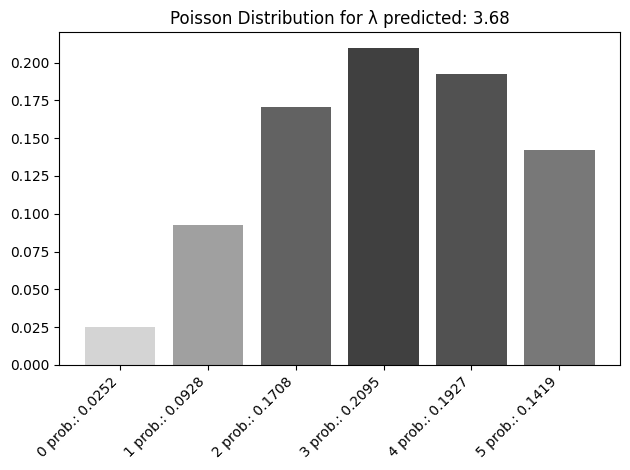

In [89]:
theme_colors = [plt.cm.Greys(0.2 + 0.6 * (p / max(probs))) for p in probs]
fig, ax = plt.subplots()
ax.bar(x_vals, probs, tick_label=labels, color=theme_colors)
ax.set_title(f"Poisson Distribution for λ predicted: {lambda_predicted:.2f}")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()